In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.interpolate import interp1d
from scipy.optimize import root
import importlib
import classy
from scipy.special import sici
from classy import Class


In [2]:
common_settings = {
'omega_b':0.0223828,
'h':0.67810,
'z_reio':7.6711,
'YHe':0.25,
'perturbations_verbose':1,
'background_verbose':3,
'output':'mTk, vTk, mPk',
'gauge':'newtonian',
'P_k_max_1/Mpc':10,
'z_max_pk':1000,
'format':'class',
}

In [5]:
# ChatGPT says that 1 eV = 4.827e19 invMpc
chiCDM = Class()
chiCDM.set(common_settings)
m_ax= 1.e-24*1.56e29
chiCDM.set({
'N_ur': 3.046,
'omega_cdm':0.01 ,
'omega_chi':0.11 ,
'm_ax':m_ax,
})

# chiCDM.compute()
#get the growth factor of a LCDM equivalent
pureCDM = Class()
pureCDM.set(common_settings)
pureCDM.set({
    'N_ur': 3.046,
    'omega_cdm':0.12,
})
pureCDM.compute()


Running CLASS version v3.2.5
Computing background
Chose ndf15 as generic_evolver
 -> age = 13.773513 Gyr
 -> conformal age = 14156.086532 Mpc
 -> N_eff = 3.046 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3402.266936
    corresponding to conformal time = 112.823156 Mpc
 ---------------------------- Budget equation ----------------------- 
 ---> Nonrelativistic Species 
-> Bayrons                        Omega = 0.0486773       , omega = 0.0223828      
-> Cold Dark Matter               Omega = 0.260972        , omega = 0.12           
 ---> Relativistic Species 
-> Photons                        Omega = 5.37815e-05     , omega = 2.47298e-05    
-> Ultra-relativistic relics      Omega = 3.72044e-05     , omega = 1.71073e-05    
 ---> Other Content 
-> Cosmological Constant          Omega = 0.69026         , omega = 0.317395       
 ---> Total budgets 
 Radiation                        Omega = 9.09859e-05     , omega = 4.18371e-0

Running CLASS version v3.2.5
Computing background
Chose ndf15 as generic_evolver
 -> age = 13.773513 Gyr
 -> conformal age = 14156.113762 Mpc
 -> N_eff = 3.046 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3402.266936
    corresponding to conformal time = 112.850386 Mpc
 ---------------------------- Budget equation ----------------------- 
 ---> Nonrelativistic Species 
-> Bayrons                        Omega = 0.0486773       , omega = 0.0223828      
-> Cold Dark Matter               Omega = 0.0217477       , omega = 0.01           
-> Dark Matter with sound speed (ULAs version): Omega = 0.239224        , omega = 0.11           
 ---> Relativistic Species 
-> Photons                        Omega = 5.37815e-05     , omega = 2.47298e-05    
-> Ultra-relativistic relics      Omega = 3.72044e-05     , omega = 1.71073e-05    
 ---> Other Content 
-> Cosmological Constant          Omega = 0.69026         , omega = 0.317395       
 

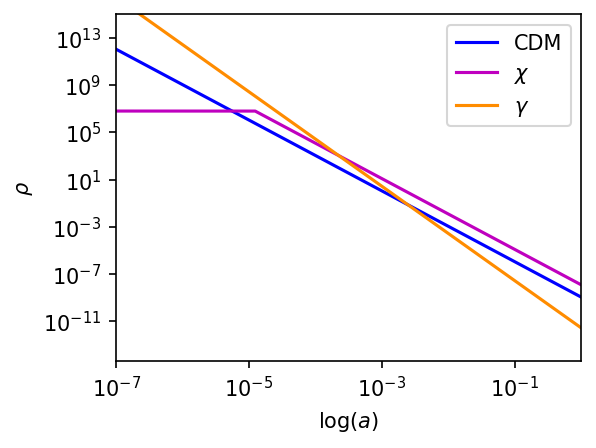

In [6]:
plt.figure(figsize=(4,3), dpi=150)

chibck = chiCDM.get_background() # load background table
a = 1/(chibck['z']+1) # read redshift
rho_cdm=chibck['(.)rho_cdm']
rho_chi=chibck['(.)rho_chi']
rho_g=chibck['(.)rho_g']
rho_crit=chibck['(.)rho_crit']

plt.xlabel(r'$a $')
plt.loglog(a,rho_cdm, 'b', label=r'CDM')
plt.loglog(a,rho_chi, 'm', label=r'$\chi$')
plt.loglog(a,rho_g,'darkorange', label=r'$\gamma$')

rho_g=pureCDM.get_background()['(.)rho_g']
rho_cdm=pureCDM.get_background()['(.)rho_cdm']

# plt.loglog(a,rho_g,'darkorange', linestyle='--')
# plt.loglog(a,rho_cdm,'b--')



plt.xlim([1.e-7,1])
plt.ylim([None,1.e15])
plt.legend(loc='best')
plt.xscale('log')
plt.xlabel(r'$\log(a)$')
plt.ylabel(r'$\rho$')
plt.show()


In [7]:
h = chiCDM.h() # get reduced Hubble for conversions to 1/Mpc
kJ_chi=chibck['(.)kJ_chi']

Ha=a*chibck['H [1/Mpc]']
Ha_chi_int=interp1d(a,Ha)

---
now look at transfer functions

1.0059525005164547


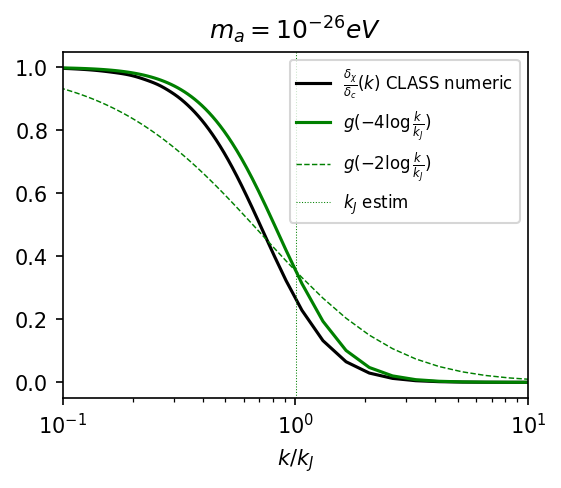

In [25]:
zeval = 0.5
chi_tk_k = chiCDM.get_transfer(z=zeval)

kEval=chi_tk_k['k (h/Mpc)']
d_chi_k=-chi_tk_k['d_chi']
d_cdm_k=-chi_tk_k['d_cdm']

T_ratio_k =d_chi_k/ d_cdm_k

def g_an(t):
    return  1 + 6 * np.exp(-t) * np.cos(np.sqrt(6) * np.exp(-t / 2)) * sici(np.sqrt(6) * np.exp(-t / 2))[1] - 3 * np.exp(-t) * np.pi * np.sin(np.sqrt(6) * np.exp(-t / 2)) + 6 * np.exp(-t) * np.sin(np.sqrt(6) * np.exp(-t / 2)) * sici(np.sqrt(6) * np.exp(-t / 2))[0]

H0p5 = Ha_chi_int(0.666)/0.666
kJ0p5 = np.sqrt(H0p5 * m_ax)/0.67810

print(kJ0p5)
plt.figure(figsize=(4,3), dpi=150)
plt.plot(kEval, T_ratio_k,'k',label=r'$\frac{\delta_\chi}{\delta_c}(k)$ CLASS numeric')
plt.plot(kEval, g_an(-4*np.log(kEval/(kJ0p5))),'g',label=r'$g(-4\log \frac{k}{k_J})$')
plt.plot(kEval, g_an(-2*np.log(kEval/(kJ0p5))),'g--',linewidth=0.7, label=r'$g(-2\log \frac{k}{k_J})$')

plt.axvline(kJ0p5, color='g', linestyle=':', linewidth=0.5,label=r'$k_J$ estim')


plt.xscale('log')
plt.xlabel(r'$k/k_J$')
plt.legend(loc='upper right', fontsize=8)
plt.xlim([1.e-1,1.e1])
plt.title(r'$m_a = 10^{-26}eV$')
plt.show()

In [14]:
H0=Ha_chi_int(1.)
print(f'{H0/0.67810:.3e}')
h= 0.67810
m_ax_eV = 1.e-26
kJest = np.sqrt(3.336e-04 * h * m_ax_eV * 1.56e29)/h * (0.6666)**0.25
print(kJest,kJ0p5 )


3.336e-04
0.791579931614926 0.10059525005164548


In [5]:
# H0=Ha_chi_int(1.)
print(0.0002982)
print(1.e-26*1.56e29)
# kJ0 = np.sqrt(H0 * 1.e-26*1.56e29)/0.67810
# kJest = kJ0 * (0.6666)**0.25

0.0002982
1560.0


----
now look at the power spectrum

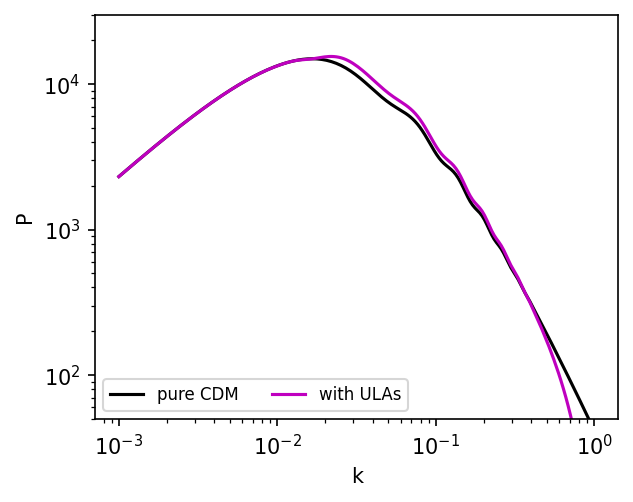

2.3010299956639813 -0.3010299956639812


In [15]:
kk = np.logspace(-3.,0.,200); h = chiCDM.h(); Pk_list=[]
for k in kk:
    Pk_list.append([chiCDM.pk_cb_lin(k*h,0.5)*h**3,pureCDM.pk_lin(k*h,0.5)*h**3]) # function .pk(k,z)
Pk_list=np.array(Pk_list).T

plt.figure(figsize=(4.5,3.5), dpi=150)
plt.plot(kk, Pk_list[1], 'k', label=f'pure CDM')
plt.plot(kk, Pk_list[0],'m', label=f'with ULAs')

plt.ylim([50,3e4])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('P')
plt.legend(loc='lower left', fontsize=8, ncol=2)

plt.show()
print(np.log10(200),np.log10(0.5))